In [1]:
import gurobipy as gb
import networkx as nx
import matplotlib.pyplot as plt
import os


#
# Drawing 
# functions
#


def DrawInitG(G, withedges=False):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}
    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='white',
                           edgecolors='black',
                           label=[G.nodes()])
        
    nx.draw_networkx_labels(G, pos=pos, font_color='k', font_size=8)
    
    if withedges:
        nx.draw_networkx_edges(G,pos=pos, alpha=1.0)
        labels = {(i,j):G.get_edge_data(i,j,'cost').get('cost') for i,j in G.edges()}
        nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=labels)
    
    plt.axis('off')
    plt.show()
    
def DrawSol(G, x):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}

    
        

    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='white',
                           edgecolors='black',
                           label=[G.nodes()])
    
    
    nx.draw_networkx_labels(G, pos=pos, font_color='k', font_size=8)
    
    for u,v in G.edges():
        if x[u,v].x > 0.01 and x[u,v].x < 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='r')
            
            nx.draw_networkx_edge_labels(G, pos=pos,
                                         edge_labels={(u,v):'{:.2f}'.format(x[u,v].x)})
        
        if x[u,v].x > 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='k')
        


        
        
    
    plt.axis('off')
    plt.show()


def DrawSubtour (G, x, subtour):

    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}


    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='white',
                           edgecolors='black',
                           label=[G.nodes()])
    
    
    nx.draw_networkx_labels(G, pos=pos, font_color='k', font_size=8)
    
    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o',
                           nodelist=subtour,
                           node_size=600,
                           node_color='white',
                           edgecolors='black',
                           label=[G.nodes()])
        
    

    nx.draw_networkx_labels(G, pos=pos, font_color='k', font_size=8)
    
    
    subtouredges = [(u,v) for u in subtour for v in subtour if u != v and G.has_edge(u,v)]
    
    for u,v in subtouredges:
        if x[u,v].x > 0.01 and x[u,v].x < 0.99:

            nx.draw_networkx_edges(G, pos=pos,\
                                   edgelist=[(u,v)],
                                   edge_color='r')

            nx.draw_networkx_edge_labels(G, pos=pos, 
                                         edge_labels={(u,v):f'[{x[u,v].x:.2f}, {x[v,u].x:.2f}]'})

            
        if x[u,v].x > 0.9:
            nx.draw_networkx_edges(G, pos=pos,\
                                   edgelist=[(u,v)],\
                                   edge_color='k')
            
    plt.axis('off')
    plt.show()
    
class args:
    filename = None
    scale = 15
    figsize = (10,10)

## ATSP

>**Given**
>A directed graph $G=(N,A)\;$ and a cost (length, distance) $c_{ij} > 0$ for each arc in $A$
>
>**Find**
> The tour (a directed cycle that touch exactly once all $n$ nodes) of minimum cost (length, distance)  


### Formulation

Decision variables:
$$
x_{ij} = \begin{cases}1 \text{ if arc $(i, j)$ is in the tour} \\
0 \text{ otherwise}
\end{cases}
$$

Formulation:
$$
\begin{alignat}{3}
& \min \sum_{(i,j) \in A} c_{ij} x_{ij} &\\
\text{s.t.} \;\;\;\;\;&\\
\sum_{j \in \delta^+(i)} x_{ij} &= 1 \;\; \forall i \in N \;\; \text{(FS)}\\
\sum_{j \in \delta^-(i)} x_{ji} &= 1 \;\; \forall i \in N \;\; \text{(RS)}\\
\sum_{(i,j) \in A(S)} x_{ij} &\le |S| - 1 \;\; \forall S \subset N, |S| \ge 2 \;\; \text{(SEC)}\\
x & \in \{0,1\}^{|A|}
\end{alignat}
$$

In [64]:
# 
# Read the graph in the graphML format
#


args.filename = 'atspexample.gml'
args.figsize =  (20,30)

basename = os.path.splitext(args.filename)[0]

G = nx.read_graphml (args.filename, node_type=int)

print ("G has", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")

print(G.is_directed())


G has 12 nodes and 132 edges
True


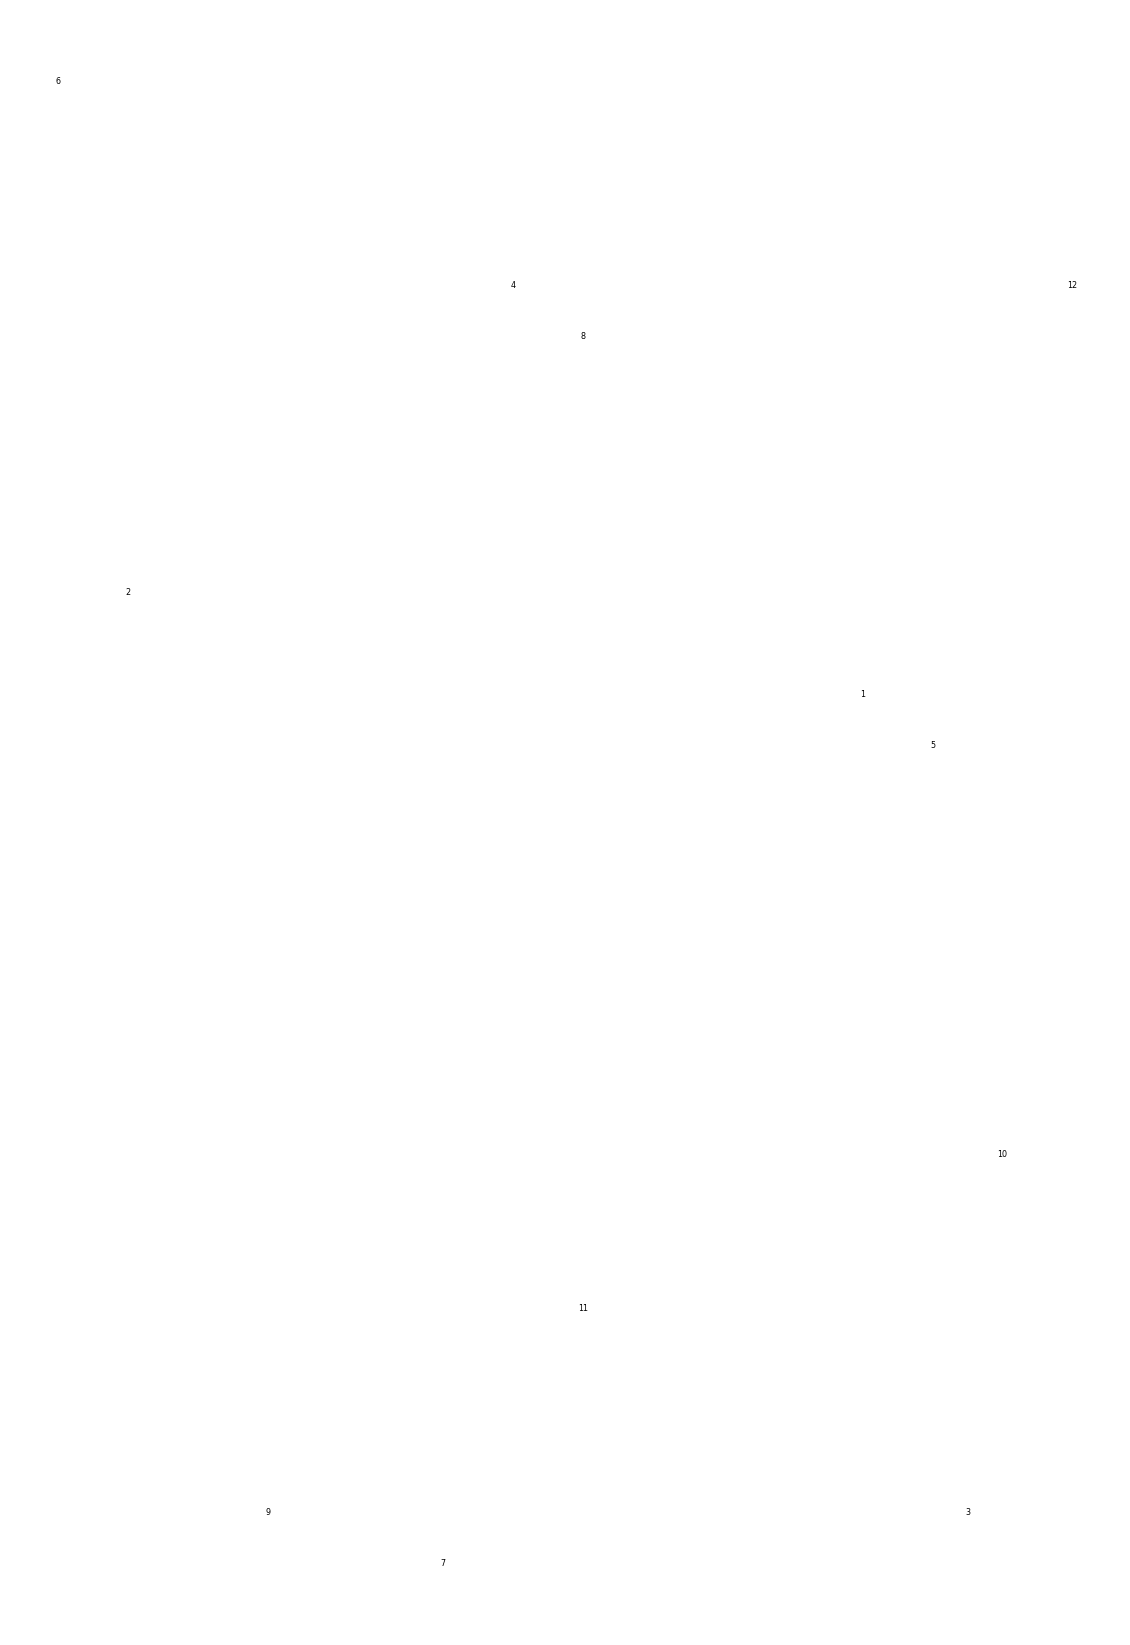

In [65]:

root = 1

DrawInitG(G)



In [66]:
atsp = gb.Model()

x = atsp.addVars(G.edges(), ub=1.0, obj=[G[i][j]['dist'] for i,j in G.edges()],
                 vtype=gb.GRB.CONTINUOUS, name='x')

atsp.write('atsp.lp')

## FS constraints

In [60]:
atsp.addConstrs((x.sum(i,'*') == 1 for i in G.nodes()), name='FS')

atsp.update()
atsp.write('atsp.lp')

## RS constraints

In [61]:
atsp.addConstrs((x.sum('*',i) == 1 for i in G.nodes()), name='RS')

atsp.update()
atsp.write('atsp.lp')

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 24 rows, 132 columns and 264 nonzeros
Model fingerprint: 0x46151ab4
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+02, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.01s
Presolved: 24 rows, 132 columns, 264 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.5310000e+03   4.000000e+00   0.000000e+00      0s
       3    8.7580000e+03   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.02 seconds
Optimal objective  8.758000000e+03


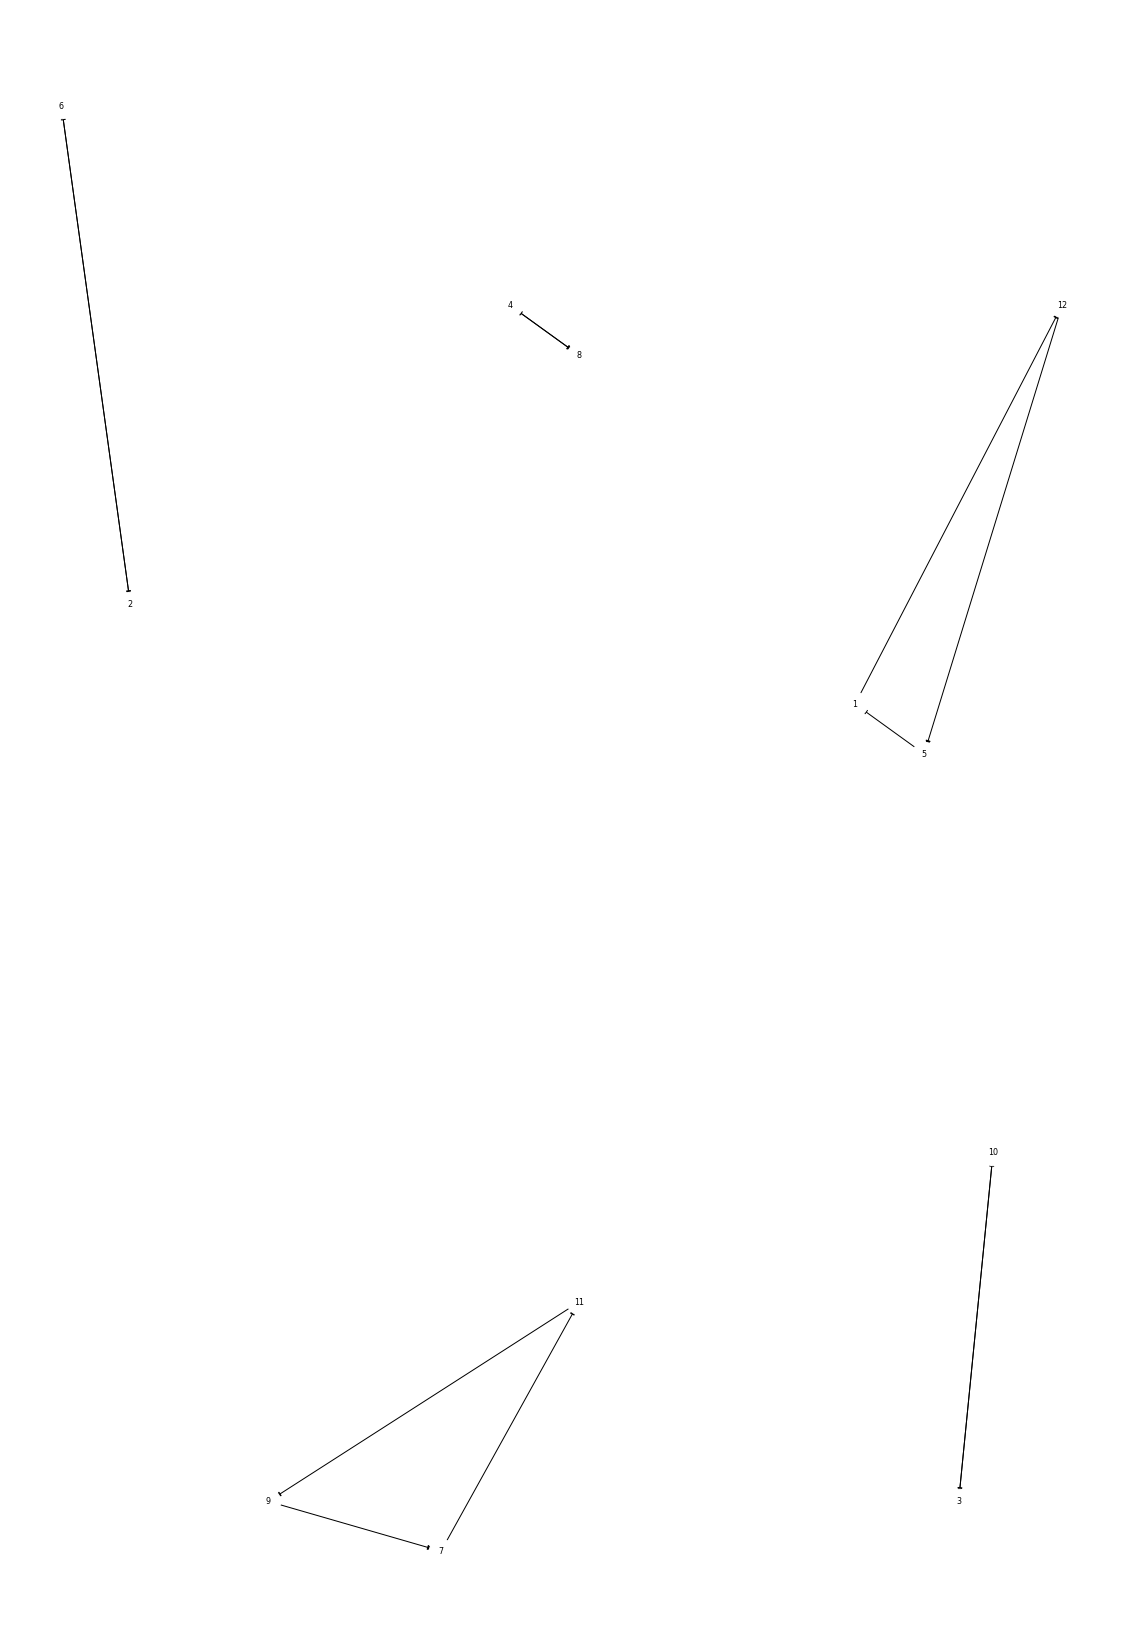

In [62]:
atsp.optimize()

DrawSol(G, x)



### SEC with |S|=2

$$ x_{ij} + x_{ji} \le 1 \;\; \forall (i,j) \in A, i <j $$

In [47]:
atsp.addConstrs((x[i,j] + x[j,i] <= 1 for i,j in G.edges() if j > i), name='SEC2')

atsp.update()
atsp.write('atsp.lp')

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 90 rows, 132 columns and 396 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+02, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.7580000e+03   3.000000e+00   0.000000e+00      0s
      18    1.1295000e+04   0.000000e+00   0.000000e+00      0s

Solved in 18 iterations and 0.02 seconds
Optimal objective  1.129500000e+04


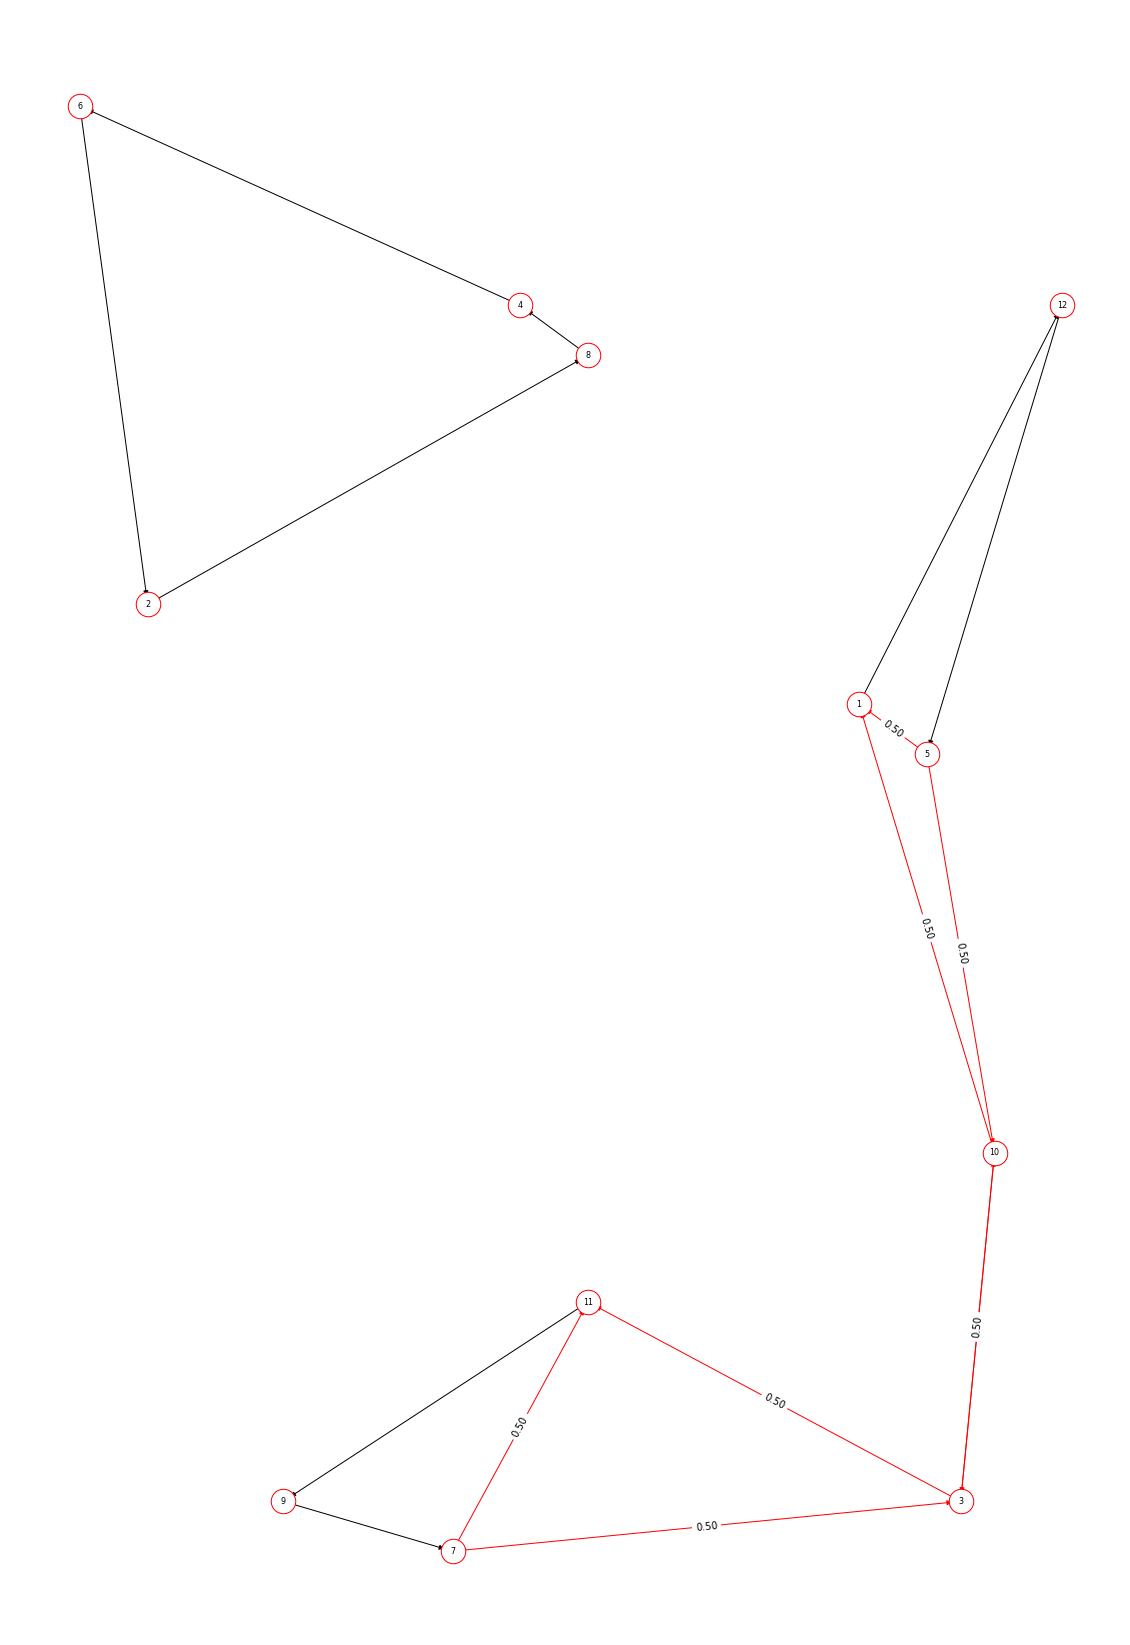

In [48]:
atsp.optimize()
DrawSol(G, x)


## Subtour Elimination Constraints: separation

The presence of the (FS) and (RS) constraints allows to rewrite the SECs in the following form (connectivity constraints)

$$ \sum_{i \in S, j \in \bar S} x_{ij} \ge 1 \;\; \forall S, 2 \le |S| \le |N|-1 $$

In [49]:
def subtourseparation (G, x):
   
    for i,j in G.edges():
        G[i][j]['capacity'] = x[i,j].x
        
    for i in list(G.nodes())[1:]:
        cut_val, cut = nx.minimum_cut(G,1,i)
        
        if cut_val < 0.99999:
            print ('Found violated subtour inequality')
            
            if len(cut[0]) < len(cut[1]):
                subtour = (list(cut[0]))
            else:
                subtour = (list(cut[1]))
            print (subtour)
            return subtour
        
    return None

## A basic cutting plane algorithm

Found violated subtour inequality
[8, 2, 4, 6]


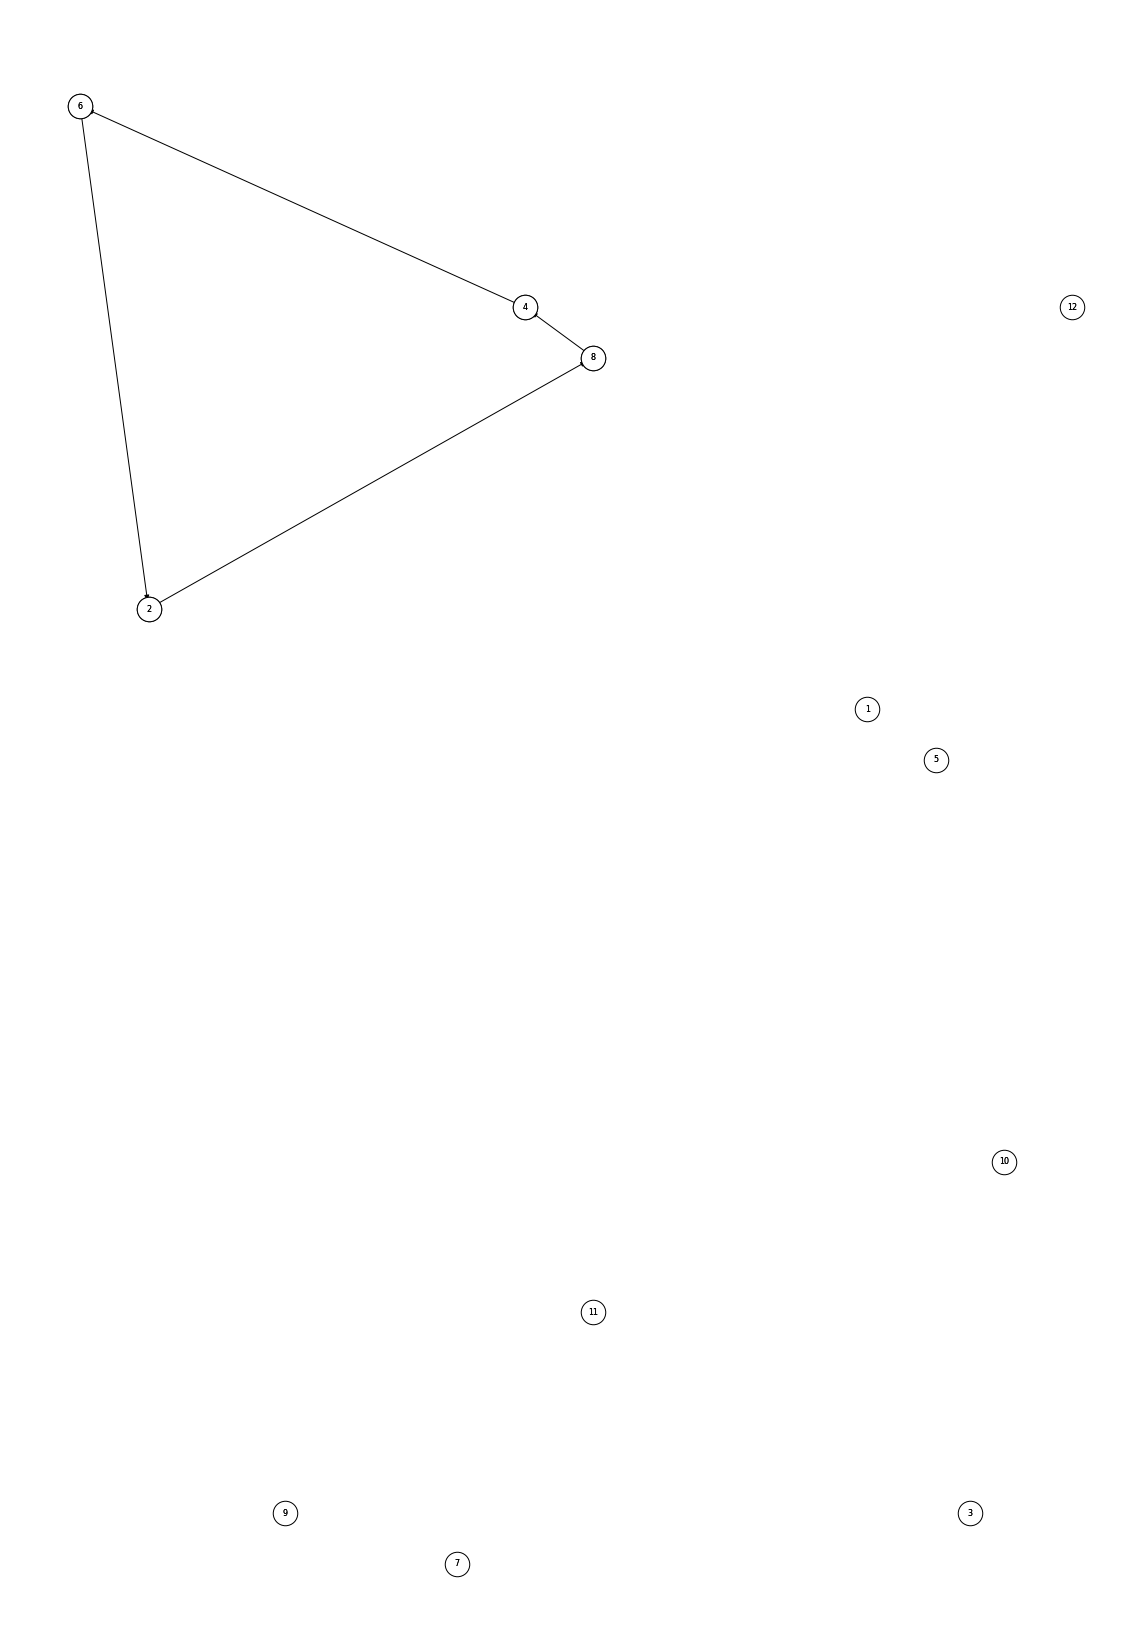

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 91 rows, 132 columns and 408 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+02, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1295000e+04   1.000000e+00   0.000000e+00      0s
       1    1.1313000e+04   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.131300000e+04


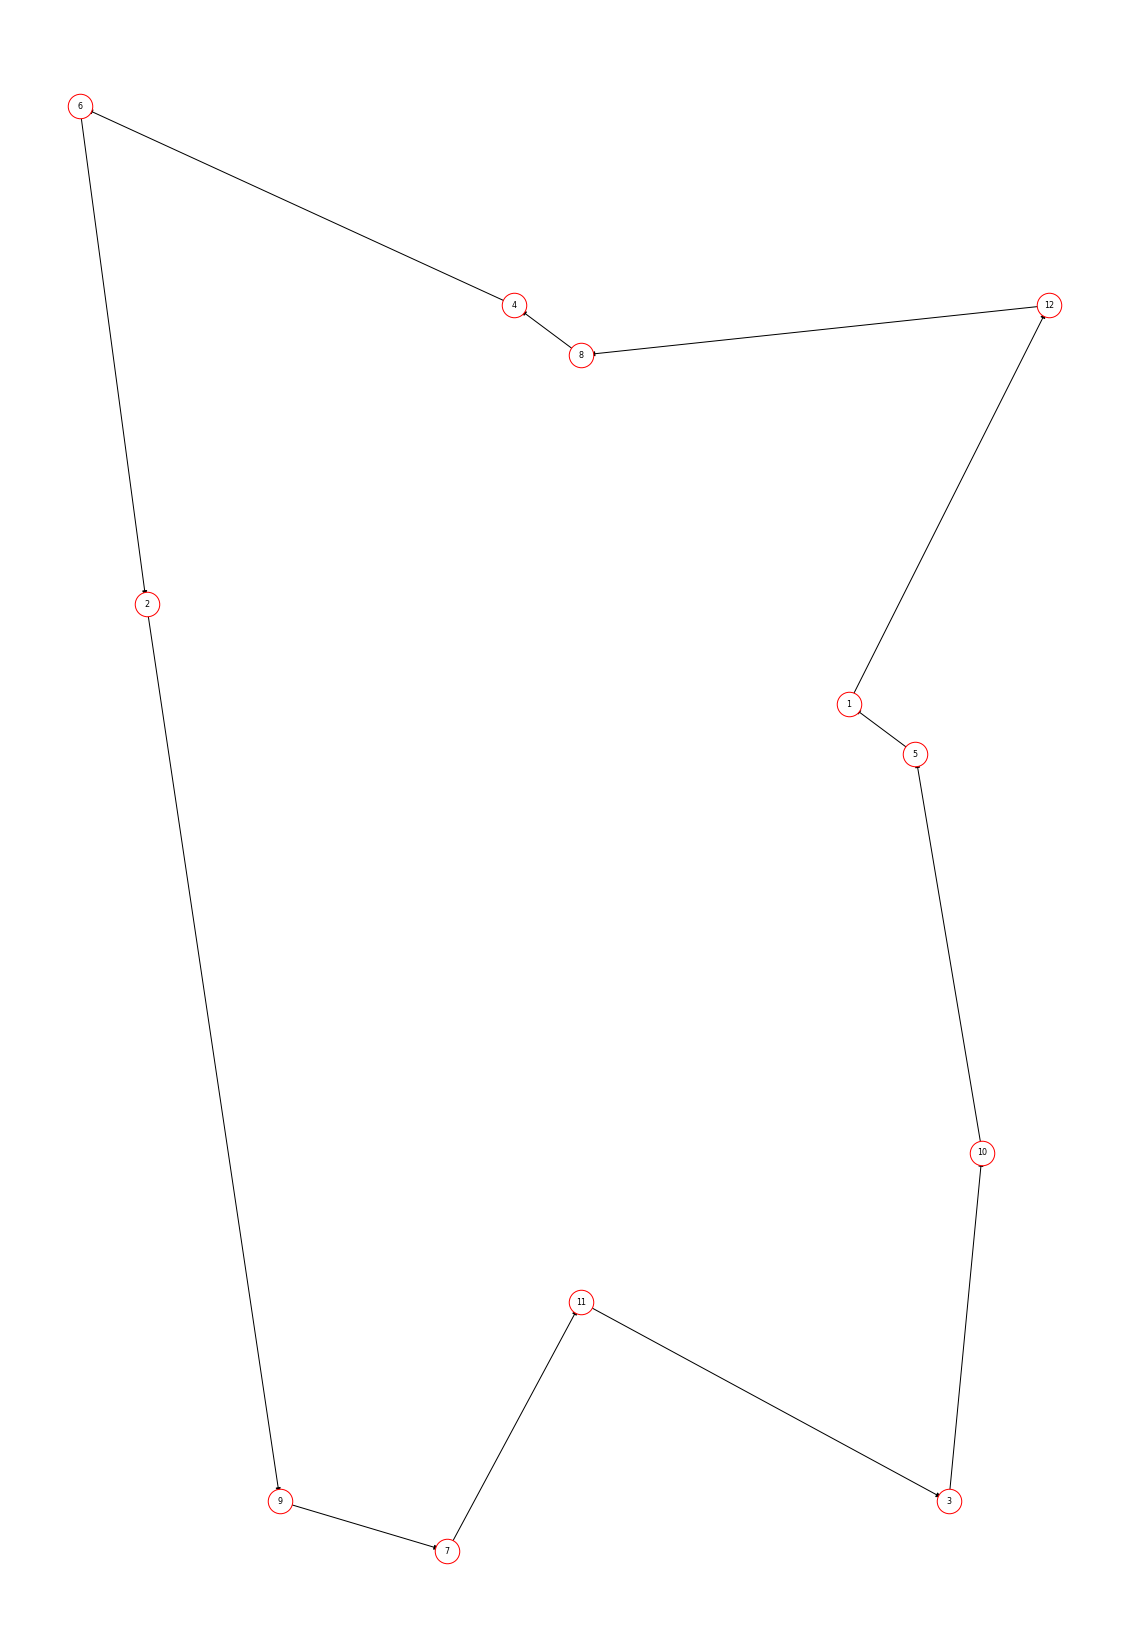

In [50]:
cuttingplane = True

count = 1
found = False

while cuttingplane == True:
    
    subtour = subtourseparation(G,x)
    
    if subtour :
        name = "Subtour_" + str(count)
        
        subtouredges = [(u,v) for u in subtour for v in subtour if u != v and G.has_edge(u,v)]
        
        DrawSubtour(G, x, subtour)
        
        atsp.addConstr (gb.quicksum(x[i,j] for i,j in subtouredges) <= len(subtour) - 1, name)
        atsp.write('atsp.lp')
        atsp.optimize()
        
        DrawSol(G, x) 
        
        count += 1
        cuttingplane = True
    else:
        cuttingplane = False




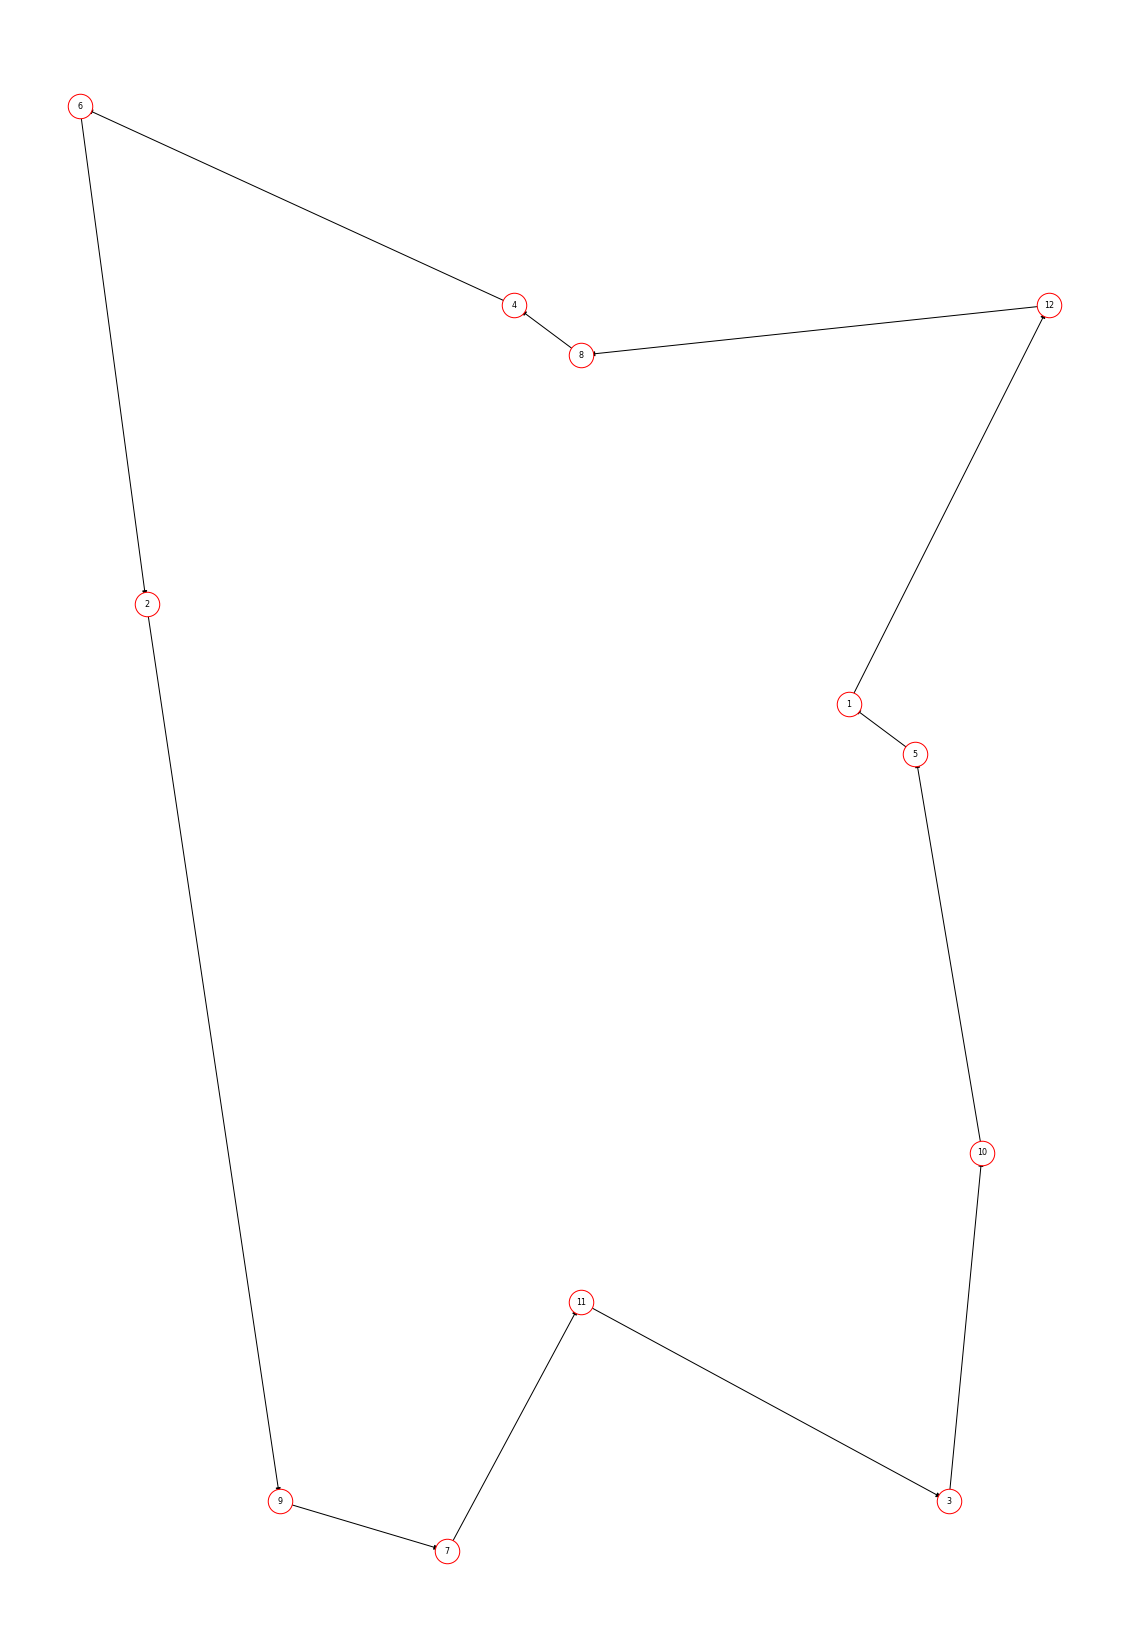

In [51]:
DrawSol(G,x)



## ATSP: Branch-and-cut

In [52]:
atsp_sec = gb.Model()

x = atsp_sec.addVars(G.edges(),
                     obj=[G[i][j]['dist'] for i,j in G.edges()],
                     vtype=gb.GRB.BINARY, name='x')

atsp_sec.write('atsp_sec.lp')

In [53]:
atsp_sec.addConstrs((x.sum(i,'*') == 1 for i in G.nodes()), name='FS')
atsp_sec.update()

In [54]:
atsp_sec.addConstrs((x.sum('*',i) == 1 for i in G.nodes()), name='RS')
atsp_sec.update()

In [55]:
atsp_sec.addConstrs((x[i,j] + x[j,i] <= 1 for i,j in G.edges() if j > i), name='SUB2')

atsp_sec.update()
atsp_sec.write('atsp.lp')

### Graph G and variables x are made available to Gurobi model
**Note** underscore is the attribute name is mandatory

In [18]:
atsp_sec._graph = G
atsp_sec._vars = x



In [19]:
def subtourseparation (G, x):
   
    for i,j in G.edges():
        G[i][j]['capacity'] = x[i,j].x
        
    for i in list(G.nodes())[1:]:
        cut_val, cut = nx.minimum_cut(G,1,i)
        
        if cut_val < 0.99999:
            print ('Found violated subtour inequality')
            
            if len(cut[0]) < len(cut[1]):
                subtour = (list(cut[0]))
            else:
                subtour = (list(cut[1]))
            print (subtour)
            return subtour
        
    return None

The separation routine is transformed into a callback

In [20]:
def SEC_lazy_callback (model, where):

        
    if where == gb.GRB.Callback.MIPSOL:
        
        x = model._vars
        xrel = model.cbGetSolution(x)
        G = model._graph
                
        for i,j in G.edges():
            G[i][j]['capacity'] = xrel[i,j]
        
        for i in list(G.nodes())[1:]:
            cut_val, cut = nx.minimum_cut(G,1,i)
        
            if cut_val < 0.99999:
                if len(cut[0]) < len(cut[1]):
                    subtour = (list(cut[0]))
                else:
                    subtour = (list(cut[1]))
        
                
                subtouredges = [(u,v) for u in subtour for v in subtour if u != v and G.has_edge(u,v)]
                
                #print (subtour, sum( xrel[i,j] for i,j in subtouredges))
                
                model.cbLazy(gb.quicksum(x[i,j] for i,j in subtouredges) <= len(subtour) - 1)
                break
                

In [21]:
atsp_sec.reset()
atsp_sec.Params.lazyConstraints = 1
atsp_sec.optimize(SEC_lazy_callback)

Discarded solution information
Changed value of parameter lazyConstraints to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 90 rows, 132 columns and 396 nonzeros
Model fingerprint: 0x6ac24144
Variable types: 0 continuous, 132 integer (132 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+02, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 90 rows, 132 columns, 396 nonzeros
Variable types: 0 continuous, 132 integer (132 binary)

Root relaxation: objective 1.129500e+04, 32 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 11295.0000    0    8          - 11295.0000      -     -    0s
H    0     0           

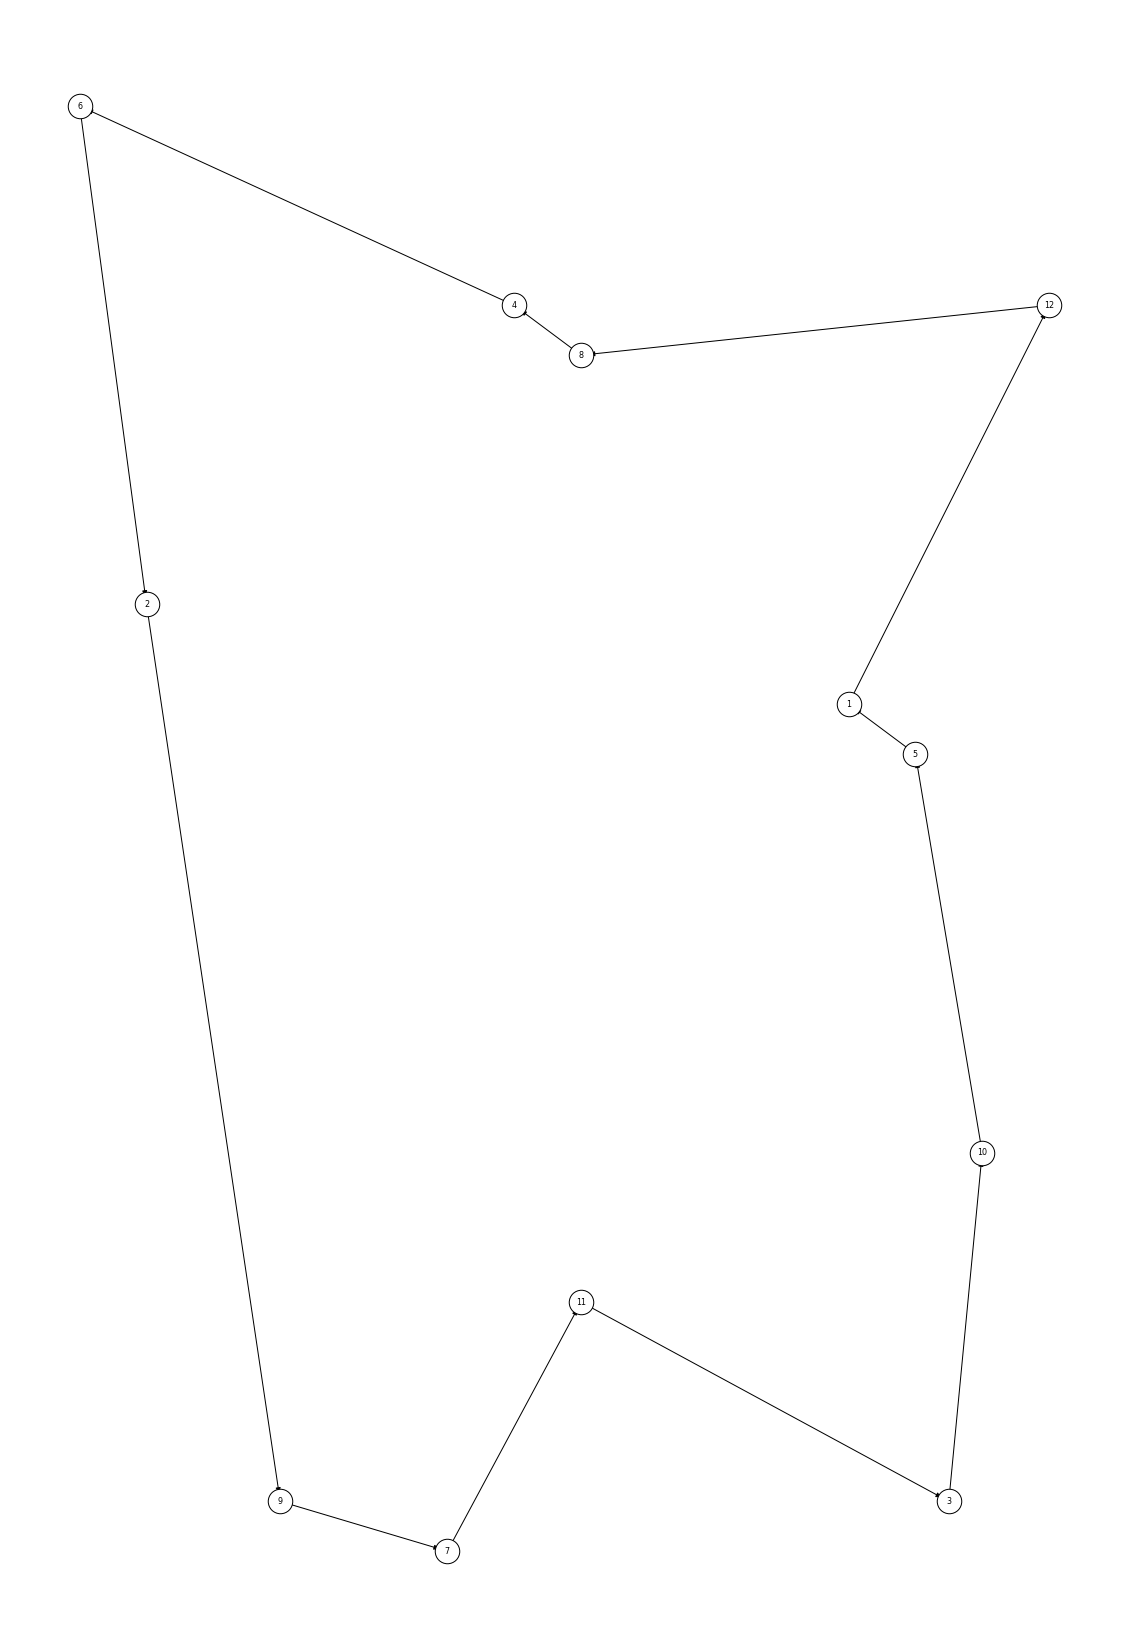

In [22]:
DrawSol(G,x)



## ATSP: compact formulation

Miller-Tucker-Zemlin formulation
$$
\begin{alignat}{3}
& \min \sum_{(i,j) \in A} x_{ij} &\\
\text{s.t.} \;\;\;\;\;&\\
\sum_{j \in \delta^+(i)} x_{ij} &= 1 \;\; \forall i \in N \;\; \text{(FS)}\\
\sum_{j \in \delta^-(i)} x_{ji} &= 1 \;\; \forall i \in N \;\; \text{(RS)}\\
u_i - u_j + 1 & \le (n-1)(1-x_{ij}) \;\; \forall (i,j) \in A, i\not=1,j\not=1 \;\; \text{(MTZ)}\\
x & \in \{0,1\}^{|A|}\\
u_1 &= 1\\
2 &\le u_i \le n \;\; \forall i \in N, i \not = \{1\}
\end{alignat}
$$

Miller-Tucker-Zemlin lifted formulation (Desrochers-Laporte)
$$
\begin{alignat}{3}
& \min \sum_{(i,j) \in A} x_{ij} &\\
\text{s.t.} \;\;\;\;\;&\\
\sum_{j \in \delta^+(i)} x_{ij} &= 1 \;\; \forall i \in N \;\; \text{(FS)}\\
\sum_{j \in \delta^-(i)} x_{ji} &= 1 \;\; \forall i \in N \;\; \text{(RS)}\\
u_i - u_j + (n-1)x_{ij} + (n-3)x_{ji} &\le n-2 \;\; \forall (i,j) \in A, i\not=1,j\not=1 \;\; \text{(MTZ)}\\
x & \in \{0,1\}^{|A|}\\
u_1 &= 1\\
2 &\le u_i \le n \;\; \forall i \in N, i \not = \{1\}
\end{alignat}
$$


In [23]:
atsp_mtz = gb.Model()

x = atsp_mtz.addVars(G.edges(),
                     obj=[G[i][j]['dist'] for i,j in G.edges()],
                     vtype=gb.GRB.BINARY, name='x')

u = atsp_mtz.addVars(G.nodes(), 
                     obj=[0.0 for i in G.nodes()],
                     lb=2.0, ub=G.number_of_nodes(), 
                     vtype=gb.GRB.CONTINUOUS,
                     name='u')

atsp_mtz.write('atsp_mtz.lp')

In [24]:
atsp_mtz.addConstrs((x.sum(i,'*') == 1 for i in G.nodes()), name='FS')

atsp_mtz.update()


In [25]:
atsp_mtz.addConstrs((x.sum('*',i) == 1 for i in G.nodes()), name='RS')

atsp_mtz.update()
atsp_mtz.write('atsp_mtz.lp')

## Lifted Miller-Tucker-Zemlin constraints

### Fixing root node

In [26]:
u[root].lb = 1.0
u[root].ub = 1.0

In [27]:
atsp_mtz.addConstrs((u[i] - u[j] + (G.number_of_nodes() - 1) * x[i,j] + \
                   (G.number_of_nodes() - 3) * x[j,i] <= (G.number_of_nodes() - 2)\
                   for i in G.nodes()\
                    for j in G.nodes()\
                   if (i != j) and (i != root) and (j !=root) \
                     and G.has_edge(i,j) and G.has_edge(j,i)), name='MTZ')

atsp_mtz.update()
atsp_mtz.write('atsp_mtz.lp')

In [28]:
atsp_mtz.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 134 rows, 144 columns and 704 nonzeros
Model fingerprint: 0x94807939
Variable types: 12 continuous, 132 integer (132 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [2e+02, 4e+03]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 1e+01]
Presolve removed 0 rows and 1 columns
Presolve time: 0.00s
Presolved: 134 rows, 143 columns, 704 nonzeros
Variable types: 11 continuous, 132 integer (132 binary)
Found heuristic solution: objective 23327.000000
Found heuristic solution: objective 22467.000000

Root relaxation: objective 1.128245e+04, 42 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 11282.4545    0   15 22467.0000 11282.4545  49.8%     -    0s
H

In [29]:
for i in u:
    print (i,u[i].x)

1 1.0
2 6.000000000000002
3 10.000000000000005
4 4.000000000000002
5 12.0
6 5.000000000000002
7 8.000000000000004
8 3.0000000000000018
9 7.0000000000000036
10 11.000000000000005
11 9.000000000000005
12 2.0


## Mixing-up formulations

In [30]:
atsp_mtz = gb.Model()

x = atsp_mtz.addVars(G.edges(),\
                 obj=[G[i][j]['dist']\
                      for i,j in G.edges()],\
             vtype=gb.GRB.BINARY, name='x')

u = atsp_mtz.addVars(G.nodes(), obj=[0.0 for i in G.nodes()],\
                     lb=2.0, ub=G.number_of_nodes(), vtype=gb.GRB.CONTINUOUS,\
                    name='u')

atsp_mtz.write('atsp_mtz.lp')

In [31]:
atsp_mtz.addConstrs((x.sum(i,'*') == 1 \
                 for i in G.nodes()), name='FS')

atsp_mtz.update()
atsp_mtz.write('atsp_mtz.lp')

In [32]:
atsp_mtz.addConstrs((x.sum('*',i) == 1 \
                 for i in G.nodes()), name='RS')

atsp_mtz.update()
atsp_mtz.write('atsp_mtz.lp')

In [33]:
atsp_mtz.addConstrs((x[i,j] + x[j,i] <= 1 \
                 for i,j in G.edges() if j > i), name='SEC2')

atsp_mtz.update()
atsp_mtz.write('atsp_mtz.lp')

In [34]:
u[root].lb = 1.0
u[root].ub = 1.0

In [35]:
atsp_mtz.addConstrs((u[i] - u[j] + (G.number_of_nodes() - 1) * x[i,j] + \
                   (G.number_of_nodes() - 3) * x[j,i] <= (G.number_of_nodes() - 2)\
                   for i in G.nodes()\
                    for j in G.nodes()\
                   if (i != j) and (i != 1) and (j !=1 ) and G.has_edge(i,j) and G.has_edge(j,i)), name='MTZ')

atsp_mtz.update()
atsp_mtz.write('atsp_mtz.lp')

In [36]:
atsp_mtz._vars = x
atsp_mtz._graph = G

The lazy cut callback will be transformed into a cut callback

In [37]:
def SEC_cut_callback (model, where):

    if where == gb.GRB.Callback.MIPNODE:
        status = model.cbGet(gb.GRB.Callback.MIPNODE_STATUS)
        count = model.cbGet(gb.GRB.Callback.MIPNODE_NODCNT)
        if status == gb.GRB.OPTIMAL and count < 10:
            x = model._vars
            xrel = model.cbGetNodeRel(x) 
            G = model._graph

            for i,j in G.edges():
                G[i][j]['capacity'] = xrel[i,j]

            for i in list(G.nodes())[1:]:
                cut_val, cut = nx.minimum_cut(G,1,i)

                if cut_val < 0.99999:
                    if len(cut[0]) < len(cut[1]):
                        subtour = (list(cut[0]))
                    else:
                        subtour = (list(cut[1]))

                    subtouredges = [(u,v) for u in subtour \
                                for v in subtour if u != v and G.has_edge(u,v)]

                    model.cbCut(gb.quicksum(x[i,j] for i,j in subtouredges) <= len(subtour) - 1)

                    break



In [38]:
atsp_mtz.reset()
atsp_mtz.Params.PreCrush = 1
atsp_sec.Params.lazyConstraints = 0
atsp_mtz.optimize(SEC_cut_callback)

Discarded solution information
Changed value of parameter PreCrush to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Changed value of parameter lazyConstraints to 0
   Prev: 1  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 200 rows, 144 columns and 836 nonzeros
Model fingerprint: 0xfe0e0710
Variable types: 12 continuous, 132 integer (132 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [2e+02, 4e+03]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 1e+01]
Presolve removed 0 rows and 1 columns
Presolve time: 0.00s
Presolved: 200 rows, 143 columns, 836 nonzeros
Variable types: 11 continuous, 132 integer (132 binary)
Found heuristic solution: objective 23327.000000
Found heuristic solution: objective 22467.000000

Root relaxation: objective 1.130155e+04, 36 iterations, 0.00 seconds

    Nodes    |    Current Nod

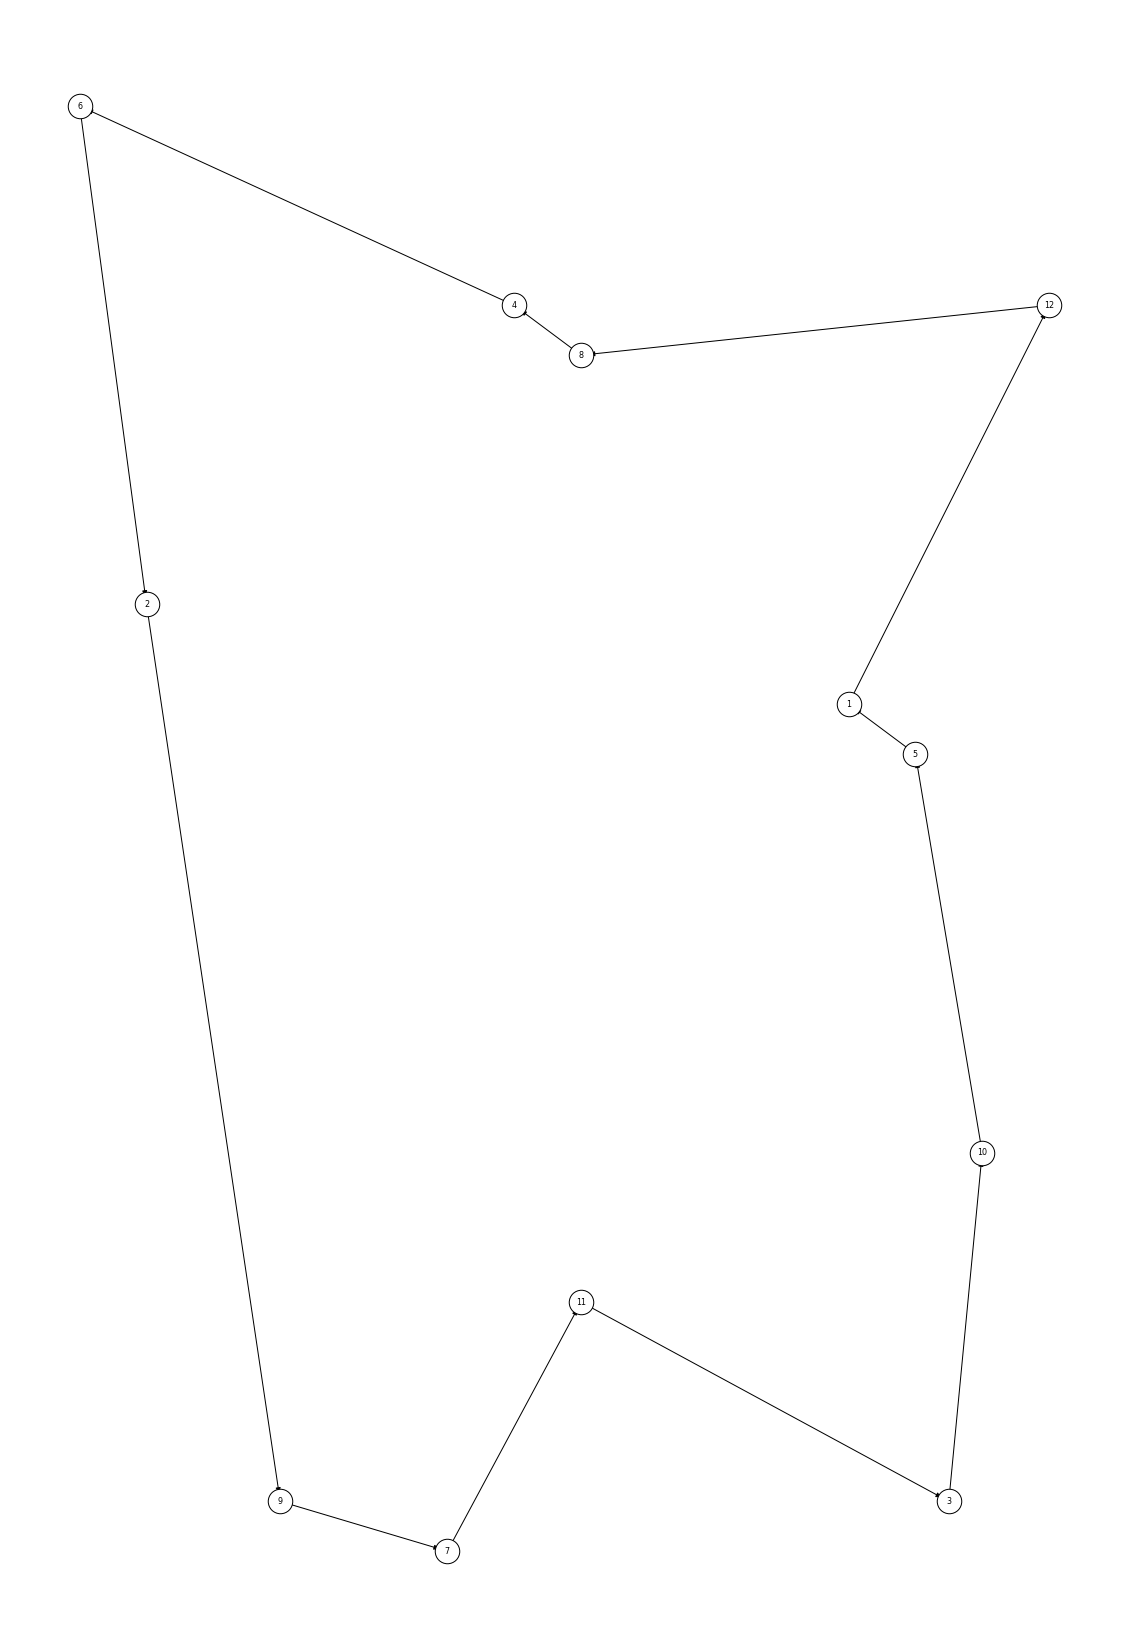

In [39]:
DrawSol(G,x)
